In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

import pandas as pd
import time
import metrics

# counterfactuals libraries
import dice_ml
from nice import NICE

import tensorflow as tf
tf.get_logger().setLevel(40) 
tf.compat.v1.disable_v2_behavior() 
from alibi.explainers import CounterfactualProto
from alibi.utils import ohe_to_ord, ord_to_ohe
from alibi.datasets import fetch_adult

/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/dice_ml/utils/exception.py:12: UserWarning: UserConfigValidationException will be deprecated from dice_ml.utils. Please import UserConfigValidationException from raiutils.exceptions.
  warnings.warn("UserConfigValidationException will be deprecated from dice_ml.utils. "
2023-10-03 16:00:31.872011: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-03 16:00:32.077090: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-03 16:00:32.080172: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-03 16:00:33.377265: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] T

# 引用数据并做一些预处理

In [2]:
dataset = pd.read_csv('data/adult.csv')
dataset.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [3]:
# 要进行counterfactual的个数
N_CF = 20

In [4]:
# 对数据添加噪声
def data_perturbation(data, epsilon):
    perturbed_data = []
    for value in data:
        noise = np.random.laplace(scale=1/epsilon)  # 使用拉普拉斯噪声
        perturbed_value = value + noise
        perturbed_data.append(perturbed_value)
    return perturbed_data

In [5]:
# 数据预处理

# clean the data, replace '?' with the most frequent value

# For 'workclass'
attrib, counts = np.unique(dataset['workclass'], return_counts=True)
most_freq_attrib = attrib[np.argmax(counts, axis=0)]
dataset.loc[dataset['workclass'] == '?', 'workclass'] = most_freq_attrib 

# For 'occupation'
attrib, counts = np.unique(dataset['occupation'], return_counts=True)
most_freq_attrib = attrib[np.argmax(counts, axis=0)]
dataset.loc[dataset['occupation'] == '?', 'occupation'] = most_freq_attrib 

# For 'native-country'
attrib, counts = np.unique(dataset['native-country'], return_counts=True)
most_freq_attrib = attrib[np.argmax(counts, axis=0)]
dataset.loc[dataset['native-country'] == '?', 'native-country'] = most_freq_attrib 

In [6]:
# 将标签转换为数字
dataset['income']=dataset['income'].map({'<=50K': 0, '>50K': 1, '<=50K.': 0, '>50K.': 1})

In [12]:
# 对age列添加噪声，epsilon=0.1
dataset['age_per'] = data_perturbation(dataset['age'], 0.1)

In [13]:
# move the 'age_per' column to the second column
cols = dataset.columns.tolist()
cols.insert(1, cols.pop(cols.index('age_per')))
dataset = dataset[cols]
dataset.head()

,age,age_per,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,34.699507,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,34.760920,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,23.587549,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,61.048739,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
4,18,22.322506,Private,103497,Some-college,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,30,United-States,0


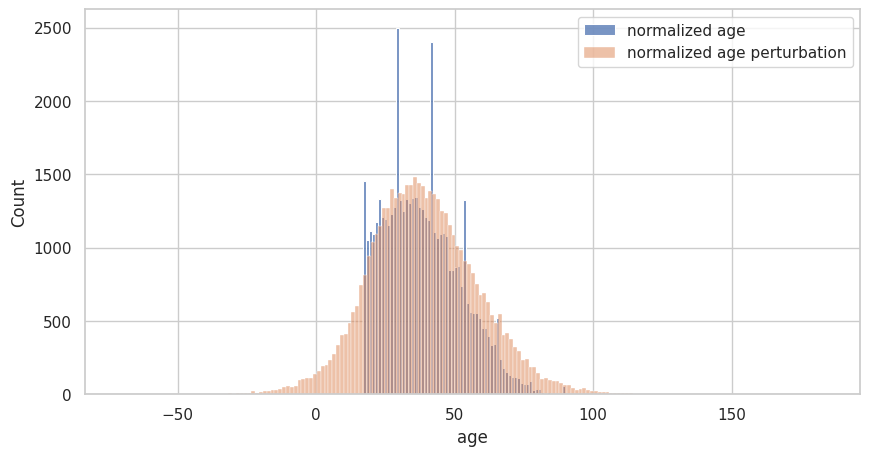

In [31]:
# plot the histogram of the age column and the age_per column
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.histplot(dataset['age'],label='normalized age')
sns.histplot(dataset['age_per'], alpha=0.5, label='normalized age perturbation')
plt.legend()

In [32]:
# 将数据集分为特征和标签
X, Y = dataset.iloc[:, :-1], dataset.iloc[:, -1]
feature_names = list(X.columns)

In [33]:
target_name = 'income'

In [34]:
# 定义连续特征和文本特征
categorical_features = ['workclass', 'education', 'marital-status','occupation','relationship','race','gender','native-country']
categorical_features_indices = [X.columns.get_loc(cat) for cat in categorical_features]

numerical_features = [f for f in X.columns if f not in categorical_features]
numerical_features_indices = [X.columns.get_loc(cat) for cat in numerical_features]

immutable_features = ['marital-status', 'race', 'native-country', 'sex']
non_decreasing_features = ['age', 'education']
correlated_features = [('education', 'age')]

# 将数据集分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# DICE 方法

In [35]:
# 因为三种方法训练模型时所使用的数据格式不同，因些需要分别对数据进行预处理
# 定义预处理管道，包括标准化和独热编码
numerical_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    sparse_threshold=0
)

preprocessor.fit(X_train)

# prepare the training and testing data
X_train_ohe = preprocessor.transform(X_train)

# 使用随机森林分类器进行分类
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_ohe, y_train)

# define the predict function
predictor = lambda x: clf.predict_proba(preprocessor.transform(x))

# result
print(classification_report(y_true=y_test, y_pred=predictor(X_test).argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91      7479
           1       0.75      0.64      0.69      2290

    accuracy                           0.87      9769
   macro avg       0.82      0.79      0.80      9769
weighted avg       0.86      0.87      0.86      9769



In [36]:
d = dice_ml.Data(dataframe=dataset, continuous_features=numerical_features, outcome_name=target_name)

# 使用sklearn作为backend
backend = 'sklearn'

# 将sklearn的预测器包装成dice_ml的预测器
class ModelWrapper:
    def __init__(self, predictor_func):
        self.predictor_func = predictor_func
    
    def predict_proba(self, instances):
        return self.predictor_func(instances)
    
    def predict(self, instances):
       
        prob_preds = self.predictor_func(instances)
    
        return np.argmax(prob_preds, axis=1)

model_wrapper = ModelWrapper(predictor)

m = dice_ml.Model(model=model_wrapper, backend=backend)

In [37]:
# 计算proximity
dice_method = "random"

dice_result = []

for i in range(N_CF):
    counterfactuals_list = []
    exp = dice_ml.Dice(d, m, method=dice_method)
    query_instance_df = pd.DataFrame([X_test.iloc[i]])
    dice_exp = exp.generate_counterfactuals(query_instance_df, total_CFs=5, desired_class="opposite")
    
    final_cfs_df = dice_exp.cf_examples_list[0].final_cfs_df
    
    counterfactuals_list.append((query_instance_df, final_cfs_df))
    
    metrics_dice = metrics.calculate_metrics(
        counterfactuals_list, dataset,
        numerical_features, categorical_features,
        preprocessor, dice_method, target_name
    )
    dice_result.append(metrics_dice)

100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


In [38]:
# calculate the average of the metrics
dice_avg_proximity_cont = np.mean([x['avg_proximity_cont'] for x in dice_result])
dice_avg_proximity_cat = np.mean([x['avg_proximity_cat'] for x in dice_result])
dice_avg_sparsity = np.mean([x['avg_sparsity'] for x in dice_result])

print(f"Average proximity for continuous features: {dice_avg_proximity_cont}")
print(f"Average proximity for categorical features: {dice_avg_proximity_cat}")
print(f"Average sparsity: {dice_avg_sparsity}")

Average proximity for continuous features: 1.182193470118983
Average proximity for categorical features: 0.04292929292929294
Average sparsity: 5.5


In [39]:
# validate and time

# Select some positive examples.
X_negative = X_test[np.argmax(predictor(X_test), axis=1) == 0]
query_instance_df = pd.DataFrame(X_negative[0:N_CF], columns=feature_names)

counterfactuals_list = []
dice_time_list = []
dice_validity_list = []

for _, instance in query_instance_df.iterrows():
    instance_df = pd.DataFrame(instance).T
    
    start_time = time.time()
    
    dice_exp = exp.generate_counterfactuals(instance_df, total_CFs=5, desired_class="opposite")
    
    time_taken = time.time() - start_time
    dice_time_list.append(time_taken)
    
    # dice_exp[0].cf_examples_list[0].final_cfs_df
    if hasattr(dice_exp, 'cf_examples_list') and dice_exp.cf_examples_list[0]:
        cf_df = dice_exp.cf_examples_list[0].final_cfs_df
        if cf_df is not None:
            counterfactuals_list.append((instance_df, cf_df))
            dice_validity_list.append(1)
        else:
            counterfactuals_list.append((instance_df, None))
            dice_validity_list.append(0)
    else:
        counterfactuals_list.append((instance_df, None))
        dice_validity_list.append(0)

dice_avg_time = np.mean(dice_time_list)
dice_avg_validity = np.mean(dice_validity_list)

print("Average Time Taken per instance:", dice_avg_time)
print("Average Validity:", dice_avg_validity) 

100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

Average Time Taken per instance: 0.5793681979179383
Average Validity: 1.0


In [40]:
dice_exp.visualize_as_dataframe()

Query instance (original outcome : 0)


,age,age_per,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,22,2.635709,Private,227994,Some-college,10,Married-spouse-absent,Adm-clerical,Own-child,Asian-Pac-Islander,Female,0,0,39,United-States,0



Diverse Counterfactual set (new outcome: 1.0)


,age,age_per,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,22,2.635709,Private,227994,1st-4th,10,Married-spouse-absent,Adm-clerical,Own-child,Asian-Pac-Islander,Female,37717.0,0,39,United-States,1
1,22,2.635709,Private,227994,Some-college,10,Married-spouse-absent,Adm-clerical,Own-child,Asian-Pac-Islander,Female,18059.0,0,39,United-States,1
2,22,2.635709,Private,227994,Some-college,10,Married-civ-spouse,Adm-clerical,Own-child,Asian-Pac-Islander,Female,93111.0,0,39,United-States,1
3,22,2.635709,Private,227994,Some-college,10,Married-spouse-absent,Adm-clerical,Other-relative,Asian-Pac-Islander,Female,92506.0,0,39,United-States,1
4,22,2.635709,Private,387499.0,Some-college,10,Married-spouse-absent,Adm-clerical,Own-child,Asian-Pac-Islander,Female,72378.0,0,39,United-States,1


# NICE 方法

In [41]:
# 首先训练一个随机森林分类器

X_nice = X.values
y_nice = Y.values

X_train_nice, X_test_nice, y_train_nice, y_test_nice = train_test_split(X_nice, y_nice, test_size=0.2, random_state=42)

clf_nice = Pipeline([
    ('preprocessor', ColumnTransformer(
        [
            ('num', numerical_transformer, numerical_features_indices),
            ('cat', categorical_transformer, categorical_features_indices)
        ]
    )),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))]
)

clf_nice.fit(X_train_nice, y_train_nice)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  [0, 1, 3, 5, 11, 12, 13]),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [2, 4, 6, 7, 8, 9, 10,
                                                   14])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [42]:
predict_fn_nice = lambda x: clf_nice.predict_proba(x)

# Initialize NICE by specifing the optimization strategy and providing the training data and predictive model.

NICE_explainer = NICE(
    X_train=X_train_nice,
    predict_fn=predict_fn_nice,
    y_train=y_train_nice,
    cat_feat=categorical_features_indices,
    num_feat=numerical_features_indices
)

In [43]:
# 计算proximity

nice_result = []

for i in range(N_CF):
    counterfactuals_list_nice = []
    
    query_instance_df_nice = pd.DataFrame(X_test_nice[i:i+1,:], columns=feature_names)
    nice_exp = NICE_explainer.explain(X_test_nice[i:i+1,:])[0]

    final_cfs_nice = pd.DataFrame([nice_exp], columns=feature_names)
    final_cfs_nice[target_name] = clf_nice.predict(final_cfs_nice)
    
    counterfactuals_list_nice.append((query_instance_df_nice, final_cfs_nice))
    
    metrics_nice = metrics.calculate_metrics(
        counterfactuals_list_nice, dataset,
        numerical_features, categorical_features,
        preprocessor,'nice',target_name
    )
    nice_result.append(metrics_nice)

/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: U

In [44]:
counterfactuals_list_nice

[(    age    age_per workclass    fnlwgt  education educational-num  \
  0  37.0  41.244925   Private  472517.0  Assoc-voc            11.0   
  
    marital-status     occupation   relationship   race  gender capital-gain  \
  0       Divorced  Other-service  Not-in-family  White  Female          0.0   
  
    capital-loss hours-per-week native-country  
  0          0.0            4.0  United-States  ,
      age    age_per workclass    fnlwgt  education  educational-num  \
  0  30.0  24.239949   Private  472517.0  Assoc-voc             11.0   
  
    marital-status occupation   relationship   race  gender  capital-gain  \
  0       Divorced      Sales  Not-in-family  White  Female           0.0   
  
     capital-loss  hours-per-week native-country  income  
  0           0.0            40.0  United-States       1  )]

In [45]:
# calculate the average of the metrics
nice_avg_proximity_cont = np.mean([x['avg_proximity_cont'] for x in nice_result])
nice_avg_proximity_cat = np.mean([x['avg_proximity_cat'] for x in nice_result])
nice_avg_sparsity = np.mean([x['avg_sparsity'] for x in nice_result])

print(f"Average proximity for continuous features: {nice_avg_proximity_cont}")
print(f"Average proximity for categorical features: {nice_avg_proximity_cat}")
print(f"Average sparsity: {nice_avg_sparsity}")

Average proximity for continuous features: 0.7459092957010803
Average proximity for categorical features: 0.013131313131313133
Average sparsity: 4.0


In [46]:
# validate and time

X_negative_nice = X_test_nice[np.argmax(predict_fn_nice(X_test_nice), axis=1) == 0]
query_instance_df_nice = pd.DataFrame(X_negative_nice[0:N_CF], columns=feature_names)

counterfactuals_list_nice = []
nice_time_list = []
nice_validity_list = []

for _, instance in query_instance_df_nice.iterrows():
    instance_df = pd.DataFrame(instance).T
    
    start_time = time.time()
    
    nice_exp = NICE_explainer.explain(instance_df.values)
    
    time_taken = time.time() - start_time
    nice_time_list.append(time_taken)
    
    cf_df = pd.DataFrame([nice_exp[0]], columns=feature_names)
    cf_df_prob = clf_nice.predict_proba(cf_df)
    if cf_df_prob[0][1] > 0.55:
        counterfactuals_list_nice.append((instance_df, cf_df))
        nice_validity_list.append(1)
    else:
        counterfactuals_list_nice.append((instance_df, None))
        nice_validity_list.append(0) 
        
nice_avg_time = np.mean(nice_time_list)
nice_avg_validity = np.mean(nice_validity_list)

print("Average Time Taken per instance:", nice_avg_time)
print("Average Validity:", nice_avg_validity)

/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: U

Average Time Taken per instance: 0.18060213327407837
Average Validity: 0.8


/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


# PROTOTYPE 方法

In [47]:
adult = fetch_adult()
data = adult.data
target = adult.target
feature_names_alibi = adult.feature_names
category_map_tmp = adult.category_map
target_names_alibi = adult.target_names

In [48]:
data_perm = np.random.permutation(np.c_[data, target])
X_alibi = data_perm[:,:-1]
y_alibi = data_perm[:,-1]

In [49]:
# 对age列添加噪声，epsilon=0.1
age_per_alibi = data_perturbation(X_alibi[:,0], 0.1)

In [50]:
data_per = np.c_[data, age_per_alibi]
data_per.shape

(32561, 13)

In [51]:
idx = 30000
y_train_alibi, y_test_alibi = y_alibi[:idx], y_alibi[idx+1:]

X_alibi = np.c_[X_alibi[:, 1:8], X_alibi[:, 11], X_alibi[:, 0], X_alibi[:, 8:11], age_per_alibi]

feature_names_alibi = feature_names_alibi[1:8] + feature_names_alibi[11:12] + feature_names_alibi[0:1] + feature_names_alibi[8:11] + ['Age_per']

print(feature_names_alibi)

['Workclass', 'Education', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country', 'Age', 'Capital Gain', 'Capital Loss', 'Hours per week', 'Age_per']


In [52]:
# 将文本特征进行one-hot编码,并记录其位置与长度

category_map = {}
for i, (_, v) in enumerate(category_map_tmp.items()):
    category_map[i] = v 
    
cat_vars_ord = {}
n_categories = len(list(category_map.keys()))
for i in range(n_categories):
    cat_vars_ord[i] = len(np.unique(X_alibi[:, i]))
print(cat_vars_ord)

cat_vars_ohe = ord_to_ohe(X_alibi, cat_vars_ord)[1]
print(cat_vars_ohe)

{0: 9, 1: 7, 2: 4, 3: 9, 4: 6, 5: 5, 6: 2, 7: 11}
{0: 9, 9: 7, 16: 4, 20: 9, 29: 6, 35: 5, 40: 2, 42: 11}


In [53]:
categorical_features_alibi = feature_names_alibi[0:8]
numerical_features_alibi = feature_names_alibi[8:]
categorical_ids_alibi = [i for i in range(len(categorical_features_alibi))]
numerical_ids_alibi = [i for i in range(len(feature_names_alibi)) if i not in categorical_ids_alibi]

In [54]:
# 对数据进行预处理
X_num = X_alibi[:, -len(numerical_features_alibi):].astype(np.float32, copy=False)
xmin, xmax = X_num.min(axis=0), X_num.max(axis=0)
rng = (-1., 1.)
X_num_scaled = (X_num - xmin) / (xmax - xmin) * (rng[1] - rng[0]) + rng[0]

X_cat = X_alibi[:, :-len(numerical_features_alibi)].copy()
ohe = OneHotEncoder(categories='auto', sparse_output=False).fit(X_cat)
X_cat_ohe = ohe.transform(X_cat)

# 对特征位置进行重新排序，使得文本特征在前，数值特征在后
X_alibi = np.c_[X_cat_ohe, X_num_scaled].astype(np.float32, copy=False)
X_train_alibi, X_test_alibi = X_alibi[:idx, :], X_alibi[idx+1:, :]
print(X_train_alibi.shape, X_test_alibi.shape)

(30000, 58) (2560, 58)


In [55]:
# define data preprocessor
num_transf = StandardScaler()
cat_transf = OneHotEncoder(
    categories=[range(len(x)) for x in adult.category_map.values()],
    handle_unknown='ignore'
)
preprocessor_alibi = ColumnTransformer(
    transformers=[
        ('cat', cat_transf, categorical_ids_alibi),
        ('num', num_transf, numerical_ids_alibi)
    ],
    sparse_threshold=0
)

# fit data preprocessor
preprocessor_alibi = preprocessor_alibi.fit(data_per)

In [56]:
# 训练模型
clf_ablit = RandomForestClassifier(n_estimators=100, random_state=42)
clf_ablit.fit(X_train_alibi, y_train_alibi)

RandomForestClassifier(random_state=42)

In [57]:
def predict_fn(x):
    pred_prob = clf_ablit.predict_proba(x)
    return np.hstack([1 - pred_prob[:,1].reshape(-1, 1), pred_prob[:,1].reshape(-1, 1)])

In [58]:
# Initialize the explainer object
X_alibi = X_test_alibi[0].reshape((1,) + X_test_alibi[0].shape)

shape = X_alibi.shape
beta = .01
c_init = 1.
c_steps = 5
max_iterations = 500
rng = (-1., 1.)  # scale features between -1 and 1
rng_shape = (1,) + data_per.shape[1:]
feature_range = ((np.ones(rng_shape) * rng[0]).astype(np.float32), 
                 (np.ones(rng_shape) * rng[1]).astype(np.float32))

In [59]:
cf = CounterfactualProto(predict_fn,
                         shape,
                         beta=beta,
                         cat_vars=cat_vars_ohe,
                         ohe=True,  # OHE flag
                         max_iterations=max_iterations,
                         feature_range=feature_range,
                         c_init=c_init,
                         c_steps=c_steps
                        )

cf.fit(X_train_alibi, d_type='abdm', disc_perc=[25, 50, 75])

/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in

CounterfactualProto(meta={
  'name': 'CounterfactualProto',
  'type': ['blackbox', 'tensorflow', 'keras'],
  'explanations': ['local'],
  'params': {
              'kappa': 0.0,
              'beta': 0.01,
              'gamma': 0.0,
              'theta': 0.0,
              'cat_vars': {
                            0: 9,
                            9: 7,
                            16: 4,
                            20: 9,
                            29: 6,
                            35: 5,
                            40: 2,
                            42: 11}
                          ,
              'ohe': True,
              'use_kdtree': False,
              'learning_rate_init': 0.01,
              'max_iterations': 500,
              'c_init': 1.0,
              'c_steps': 5,
              'eps': (0.001, 0.001),
              'clip': (-1000.0, 1000.0),
              'update_num_grad': 1,
              'write_dir': None,
              'feature_range': (array([[-1., -1., -1., -1.

In [60]:
def describe_instance(X, explanation, target_names, eps=1e-2):
    print('Original instance: {}  -- proba: {}'.format(target_names[explanation.orig_class],
                                                       explanation.orig_proba[0]))
    print('Counterfactual instance: {}  -- proba: {}'.format(target_names[explanation.cf['class']],
                                                             explanation.cf['proba'][0]))
    print('\nCounterfactual perturbations...')
    print('\nCategorical:')
    X_orig_ord = ohe_to_ord(X, cat_vars_ohe)[0]
    X_cf_ord = ohe_to_ord(explanation.cf['X'], cat_vars_ohe)[0]
    delta_cat = {}
    for i, (_, v) in enumerate(category_map.items()):
        cat_orig = v[int(X_orig_ord[0, i])]
        cat_cf = v[int(X_cf_ord[0, i])]
        if cat_orig != cat_cf:
            delta_cat[feature_names_alibi[i]] = [cat_orig, cat_cf]
    if delta_cat:
        for k, v in delta_cat.items():
            print('{}: {}  -->   {}'.format(k, v[0], v[1]))
    print('\nNumerical:')
    delta_num = X_cf_ord[0, -4:] - X_orig_ord[0, -4:]
    n_keys = len(list(cat_vars_ord.keys()))
    for i in range(delta_num.shape[0]):
        if np.abs(delta_num[i]) > eps:
            print('{}: {:.2f}  -->   {:.2f}'.format(feature_names_alibi[i+n_keys],
                                            X_orig_ord[0,i+n_keys],
                                            X_cf_ord[0,i+n_keys]))
            

def calculate_proximity_pro(X_orig_ord, X_cf_ord, explanation, df):
    counterfactuals_list = []
    
    query_instance_df_alibi = pd.DataFrame(X_orig_ord, columns=feature_names_alibi)
    final_cfs_alibi = pd.DataFrame(X_cf_ord, columns=feature_names_alibi)
    final_cfs_alibi[target_name] = 0 if explanation.cf['proba'][0][1] < 0.5 else 1
    
    counterfactuals_list.append((query_instance_df_alibi, final_cfs_alibi))
    
    metrics_alibi = metrics.calculate_metrics(
        counterfactuals_list, df, numerical_features_alibi, 
        categorical_features_alibi, preprocessor_alibi,"prototype",target_name
    )
    
    return metrics_alibi

In [61]:
columns_per = adult.feature_names + ["Age_per"]
pd_adult = pd.DataFrame(data_per, columns=columns_per)
pd_adult["income"] = adult.target

In [62]:
y_pred_alibi=predict_fn(X_test_alibi).argmax(axis=1)
instances_alibi = X_test_alibi[y_pred_alibi == 1][:N_CF]

metrics_alibi = []
time_alibi = []
counterfactuals_list_alibi = []

for i in range(N_CF):
    
    instance = instances_alibi[i].reshape(1, -1)
    start_time = time.time()
    explanation = cf.explain(instance)
    end_take = time.time() - start_time
    time_alibi.append(end_take)
    if explanation.cf is not None:
        counterfactuals_list_alibi.append(explanation.cf['X'])
        X_orig_ord = ohe_to_ord(X_alibi, cat_vars_ohe)[0]
        X_cf_ord = ohe_to_ord(explanation.cf['X'], cat_vars_ohe)[0]
        metric= calculate_proximity_pro(X_orig_ord, X_cf_ord, explanation, pd_adult)
        metrics_alibi.append(metric)
        describe_instance(X_alibi, explanation, target_names_alibi)
    else:
        counterfactuals_list_alibi.append(None)

2023-10-03 16:21:11.526562: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
No counterfactual found!
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature 

Original instance: >50K  -- proba: [0.13 0.87]
Counterfactual instance: <=50K  -- proba: [0.53 0.47]

Counterfactual perturbations...

Categorical:
Workclass: Private  -->   Self-emp-not-inc
Education: High School grad  -->   Bachelors
Occupation: Blue-Collar  -->   White-Collar
Race: Black  -->   White

Numerical:
Capital Loss: -1.00  -->   -1.00
Hours per week: -0.20  -->   0.20


No counterfactual found!
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-package

Original instance: >50K  -- proba: [0.21 0.79]
Counterfactual instance: <=50K  -- proba: [0.51 0.49]

Counterfactual perturbations...

Categorical:
Workclass: Private  -->   Self-emp-inc
Occupation: Blue-Collar  -->   Sales
Race: Black  -->   White

Numerical:
Capital Gain: -1.00  -->   -1.00
Capital Loss: -1.00  -->   -0.13
Hours per week: -0.20  -->   -0.41


No counterfactual found!
No counterfactual found!
No counterfactual found!
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/ci

Original instance: >50K  -- proba: [0.1 0.9]
Counterfactual instance: <=50K  -- proba: [0.6 0.4]

Counterfactual perturbations...

Categorical:
Workclass: Private  -->   Federal-gov
Occupation: Blue-Collar  -->   Other
Race: Black  -->   White

Numerical:
Capital Gain: -1.00  -->   -1.00
Hours per week: -0.20  -->   -0.20


/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: Us

Original instance: >50K  -- proba: [0.3 0.7]
Counterfactual instance: <=50K  -- proba: [0.5 0.5]

Counterfactual perturbations...

Categorical:
Occupation: Blue-Collar  -->   Sales
Race: Black  -->   White

Numerical:
Capital Loss: -1.00  -->   -1.00
Hours per week: -0.20  -->   0.61


/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: Us

Original instance: >50K  -- proba: [0.2 0.8]
Counterfactual instance: <=50K  -- proba: [0.5 0.5]

Counterfactual perturbations...

Categorical:
Workclass: Private  -->   Federal-gov
Race: Black  -->   White

Numerical:
Hours per week: -0.20  -->   -0.20


No counterfactual found!
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-package

Original instance: >50K  -- proba: [0.31 0.69]
Counterfactual instance: <=50K  -- proba: [0.52 0.48]

Counterfactual perturbations...

Categorical:
Race: Black  -->   White
Country: United-States  -->   Other

Numerical:
Hours per week: -0.20  -->   -0.20


/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: Us

Original instance: >50K  -- proba: [0.43 0.57]
Counterfactual instance: <=50K  -- proba: [0.5 0.5]

Counterfactual perturbations...

Categorical:
Education: High School grad  -->   Bachelors
Race: Black  -->   White

Numerical:
Hours per week: -0.20  -->   -0.20


No counterfactual found!
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-package

Original instance: >50K  -- proba: [0.32 0.68]
Counterfactual instance: <=50K  -- proba: [0.52 0.48]

Counterfactual perturbations...

Categorical:
Race: Black  -->   White

Numerical:
Capital Loss: -1.00  -->   -1.00
Hours per week: -0.20  -->   0.00


No counterfactual found!
No counterfactual found!
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/li

Original instance: >50K  -- proba: [0.33 0.67]
Counterfactual instance: <=50K  -- proba: [0.5 0.5]

Counterfactual perturbations...

Categorical:
Occupation: Blue-Collar  -->   Admin

Numerical:
Hours per week: -0.20  -->   -0.20


/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: Us

Original instance: >50K  -- proba: [0.08 0.92]
Counterfactual instance: <=50K  -- proba: [0.52 0.48]

Counterfactual perturbations...

Categorical:
Education: High School grad  -->   Bachelors
Occupation: Blue-Collar  -->   Professional
Race: Black  -->   White

Numerical:
Capital Loss: -1.00  -->   -1.00
Hours per week: -0.20  -->   0.00
Original instance: >50K  -- proba: [0.16 0.84]
Counterfactual instance: <=50K  -- proba: [0.5 0.5]

Counterfactual perturbations...

Categorical:
Workclass: Private  -->   Federal-gov
Occupation: Blue-Collar  -->   Admin
Relationship: Husband  -->   Wife
Race: Black  -->   White
Sex: Male  -->   Female

Numerical:


/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/home/cican/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:457: Us

In [63]:
# calculate the average of the proximity metrics
pro_avg_proximity_cont = np.mean([x['avg_proximity_cont'] for x in metrics_alibi])
pro_avg_proximity_cat = np.mean([x['avg_proximity_cat'] for x in metrics_alibi])
pro_avg_sparsity= np.mean([x['avg_proximity_cat'] for x in metrics_alibi])


print(f"Average proximity for continuous features: {pro_avg_proximity_cont}")
print(f"Average proximity for categorical features: {pro_avg_proximity_cat}")
print(f"Average sparsity: {pro_avg_sparsity}")

Average proximity for continuous features: 0.14545454545454548
Average proximity for categorical features: 0.1320754716981132
Average sparsity: 0.1320754716981132


In [64]:
# validate and time
pro_avg_time = np.mean(time_alibi)

invalid_count = [cf for cf in counterfactuals_list_alibi if cf is None]
pro_avg_validity = 1 - len(invalid_count) / N_CF
print("Average Time Taken per instance:", pro_avg_time)
print("Average Validity:", pro_avg_validity)

Average Time Taken per instance: 96.33750814199448
Average Validity: 0.55


# Results

In [65]:
result_dict = {
    "Dice": {
        "proximity_cont": dice_avg_proximity_cont,
        "proximity_cat": dice_avg_proximity_cat,
        "sparsity": dice_avg_sparsity,
        "time(s)": dice_avg_time,
        "validity": dice_avg_validity
    },
    "Nice": {
        "proximity_cont": nice_avg_proximity_cont,
        "proximity_cat": nice_avg_proximity_cat,
        "sparsity": nice_avg_sparsity,
        "time(s)": nice_avg_time,
        "validity": nice_avg_validity
    },
    "Prototype": {
        "proximity_cont": pro_avg_proximity_cont,
        "proximity_cat": pro_avg_proximity_cat,
        "sparsity": pro_avg_sparsity,
        "time(s)": pro_avg_time,
        "validity": pro_avg_validity
    }
}

result = pd.DataFrame(result_dict).T.round(3)
result

,proximity_cont,proximity_cat,sparsity,time(s),validity
Dice,1.182,0.043,5.500,0.579,1.00
Nice,0.746,0.013,4.000,0.181,0.80
Prototype,0.145,0.132,0.132,96.338,0.55
